In [15]:
import functools
import os

In [16]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate, stats

In [17]:
import lib

In [18]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [19]:
shear_sim = h5py.File(
    lib.const.SIM_SHEAR_CATALOGS[shear_step],
)

In [20]:
truth_match = h5py.File(
    lib.const.SIM_MATCH_CATALOGS[shear_step],
)

In [21]:
redshift_sim = h5py.File(
    lib.const.SIM_REDSHIFT_CATALOGS[shear_step],
)

In [22]:
zbinsc = redshift_sim["sompz"]["pzdata_weighted_sompz_dz005"]["zbinsc"][:]

nz_sompz = {}
nz_true = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz_sompz = redshift_sim["sompz"]["pzdata_weighted_sompz_dz005"][f"bin{tomographic_bin}"][:]
    _nz_true = redshift_sim["sompz"]["pzdata_weighted_true_dz005"][f"bin{tomographic_bin}"][:]
    
    nz_sompz[tomographic_bin] = _nz_sompz
    nz_true[tomographic_bin] = _nz_true
    

In [23]:
bhat_sim = lib.tomography.get_tomography(shear_sim, redshift_sim, "noshear")
cell_sim = lib.tomography.get_assignment(shear_sim, redshift_sim, "noshear")
weight_sim = lib.weight.get_shear_weights(shear_sim["mdet/noshear"])
response_sim = lib.response.get_shear_response(shear_sim["mdet/noshear"])

In [24]:
shear_y6 = h5py.File(lib.const.Y6_SHEAR_CATALOG)
redshift_y6 = h5py.File(lib.const.Y6_REDSHIFT_CATALOG)

In [25]:
bhat_y6 = lib.tomography.get_tomography(shear_y6, redshift_y6, "noshear")
cell_y6 = lib.tomography.get_assignment(shear_y6, redshift_y6, "noshear")
weight_y6 = lib.weight.get_shear_weights(shear_y6["mdet/noshear"])

In [26]:
response_y6 = lib.response._get_shear_response(
    shear_y6["mdet/noshear"],
    gal_weight_file="/global/cfs/cdirs/des/y6-image-sims/inverse_variance_weight_v6.pickle",
)

---

In [39]:
_som_occupancy_sim, _, _ = stats.binned_statistic(
    cell_sim,
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
som_occupancy_sim = _som_occupancy_sim / sum(_som_occupancy_sim)

In [40]:
_som_weight_sim, _, _ = stats.binned_statistic(
    cell_sim,
    weight_sim,
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
som_weight_sim = _som_weight_sim / sum(_som_weight_sim)
# TODO

In [41]:
som_grid_response_sim, _, _ = stats.binned_statistic(
    cell_sim,
    response_sim,
    statistic="mean",
    bins=lib.const.CELL_IDS,
)

In [44]:
_mean_g1_sim = {}
# _mean_g2_sim = {}

for mdet_step in ["1p", "1m"]:
    _g1_sim = shear_sim["mdet"][mdet_step]["gauss_g_1"][:]
    _weight_sim = lib.weight.get_shear_weights(shear_sim["mdet"][mdet_step])
    _cell_sim = lib.tomography.get_assignment(shear_sim, redshift_sim, mdet_step)
    
    _sum_weight, _, _ = stats.binned_statistic(
        _cell_sim,
        _weight_sim,
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g1, _, _ = stats.binned_statistic(
        _cell_sim,
        _weight_sim * _g1_sim,
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    _mean_g1_sim[mdet_step] = _sum_g1 / _sum_weight

som_response_sim = (_mean_g1_sim["1p"] - _mean_g1_sim["1m"]) / (2 * 0.01)

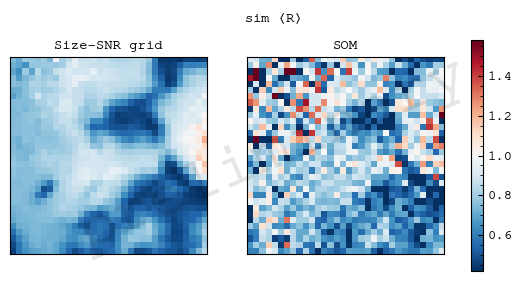

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.CenteredNorm(1)
cmap = mpl.cm.RdBu_r

im = axs[0].imshow(
    som_grid_response_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0].set_title("Size–SNR grid")

im = axs[1].imshow(
    som_response_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[1].set_title("SOM")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(
    im,
    ax=axs.ravel(),
)

fig.suptitle("sim $〈R〉$")

lib.plotting.watermark(fig)

plt.show()

In [48]:
_som_occupancy_y6, _, _ = stats.binned_statistic(
    cell_y6,
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)
som_occupancy_y6 = _som_occupancy_y6 / sum(_som_occupancy_y6)

In [49]:
_som_weight_y6, _, _ = stats.binned_statistic(
    cell_y6,
    weight_y6,
    statistic="sum",
    bins=lib.const.CELL_IDS,
)
som_weight_y6 = _som_weight_y6 / sum(_som_weight_y6)

In [50]:
som_grid_response_y6, _, _ = stats.binned_statistic(
    cell_y6,
    response_y6,
    statistic="mean",
    bins=lib.const.CELL_IDS,
)

In [199]:
_mean_g1_y6 = {}

for mdet_step in ["1p", "1m"]:
    _g1_y6 = shear_y6["mdet"][mdet_step]["gauss_g_1"][:]
    _weight_y6 = lib.weight.get_shear_weights(shear_y6["mdet"][mdet_step])
    _cell_y6 = lib.tomography.get_assignment(shear_y6, redshift_y6, mdet_step)
    
    _sum_weight, _, _ = stats.binned_statistic(
        _cell_y6,
        _weight_y6,
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g1, _, _ = stats.binned_statistic(
        _cell_y6,
        _weight_y6 * _g1_y6,
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    _mean_g1_y6[mdet_step] = _sum_g1 / _sum_weight

som_response_y6 = (_mean_g1_y6["1p"] - _mean_g1_y6["1m"]) / (2 * 0.01)

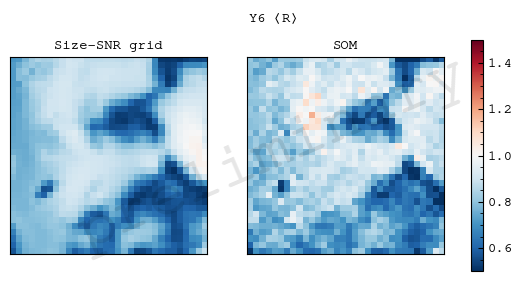

In [200]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.CenteredNorm(1)
cmap = mpl.cm.RdBu_r

im = axs[0].imshow(
    som_grid_response_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0].set_title("Size–SNR grid")

im = axs[1].imshow(
    som_response_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[1].set_title("SOM")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(
    im,
    ax=axs.ravel(),
)

fig.suptitle("Y6 $〈R〉$")

lib.plotting.watermark(fig)

plt.show()

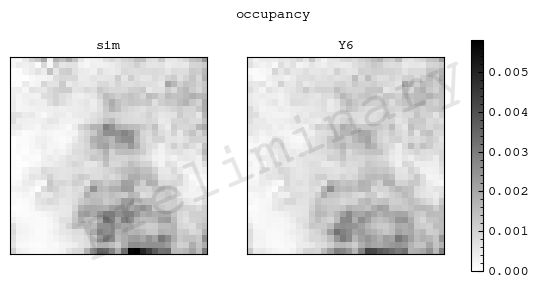

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.Normalize(vmin=0)

im = axs[0].imshow(
    som_occupancy_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[0].set_title("sim")

im = axs[1].imshow(
    som_occupancy_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[1].set_title("Y6")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(
    im,
    ax=axs.ravel(),
)

fig.suptitle("occupancy")

lib.plotting.watermark(fig)

plt.show()

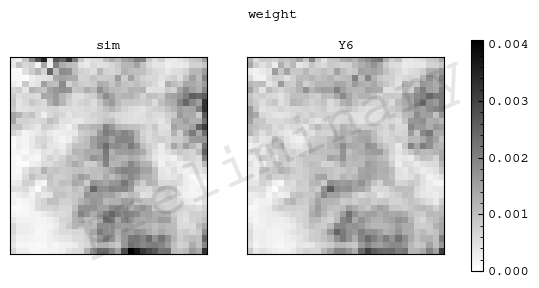

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.Normalize(vmin=0)

im = axs[0].imshow(
    som_weight_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[0].set_title("sim")

im = axs[1].imshow(
    som_weight_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[1].set_title("Y6")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(
    im,
    ax=axs.ravel(),
)

fig.suptitle("weight")

lib.plotting.watermark(fig)

plt.show()

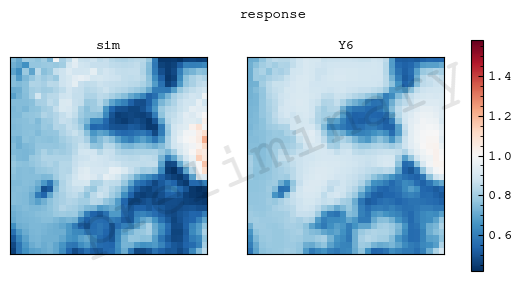

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.CenteredNorm(1)
cmap = mpl.cm.RdBu_r

im = axs[0].imshow(
    som_grid_response_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[0].set_title("sim")

im = axs[1].imshow(
    som_grid_response_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
    cmap=cmap,
)
axs[1].set_title("Y6")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

cb = fig.colorbar(
    im,
    ax=axs.ravel(),
)

fig.suptitle("response")

lib.plotting.watermark(fig)

plt.show()

---

In [56]:
zbinsc = np.arange(0.035, 4, 0.05)  # from Boyan

In [57]:
_Z = truth_match["mdet/noshear"]["z"][:]

In [58]:
_Z[_Z < zbinsc[0]] = zbinsc[0] + 0.001
_Z[_Z > zbinsc[-1]] = zbinsc[-1] - 0.001

In [59]:
zedges = np.arange(0.01, 4.02, 0.05)  # from Boyan
# _zedges = np.append([0], zedges)

In [60]:
# _nz, _, _, _ = stats.binned_statistic_2d(
#     cell_sim,
#     truth_match["mdet/noshear"]["z"],
#     weight_sim * response_sim,
#     statistic="sum",
#     bins=[lib.const.CELL_IDS, _zedges],
# )

# # reassign objects in [0.00, 0.01) to [0.01, 0.06)
# _nz[:, 1] += _nz[:, 0]
# _nz[:, 0] = 0
# _nz = np.delete(_nz, (0), axis=1)

In [164]:
response_sim

array([0.77072054, 0.7035484 , 0.23026276, ..., 0.40341375, 0.92482677,
       0.40341375])

In [172]:
a1 = np.array([
    response_sim[i]
    for (i, cell) in enumerate(cell_sim)
    if np.isfinite(cell)
])

In [173]:
a2 = np.array([
    som_grid_response_sim[cell.astype(int)]
    for cell in cell_sim
    if np.isfinite(cell)
])

In [174]:
a3 = np.array([
    som_response_sim[cell.astype(int)]
    for cell in cell_sim
    if np.isfinite(cell)
])

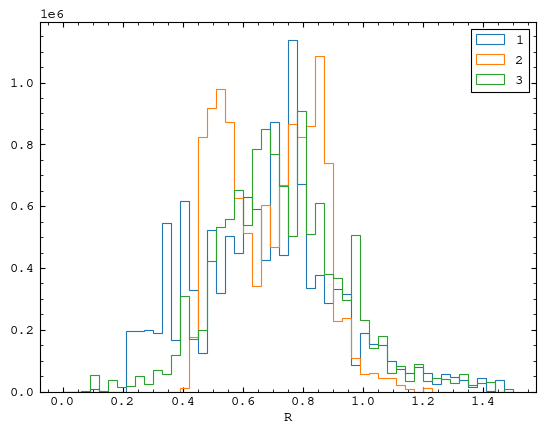

In [177]:
_bins = np.linspace(0.0, 1.5, 51)

plt.hist(a1, _bins, histtype="step", label="1")
plt.hist(a2, _bins, histtype="step", label="2")
plt.hist(a3, _bins, histtype="step", label="3")
plt.legend()
plt.xlabel("R")

plt.show()

In [179]:
_nz_raw, _, _, _ = stats.binned_statistic_2d(
    cell_sim,
    _Z,
    weight_sim,
    statistic="sum",
    bins=[lib.const.CELL_IDS, zedges],
)

In [93]:
_nz, _, _, _ = stats.binned_statistic_2d(
    cell_sim,
    _Z,
    weight_sim * response_sim,
    statistic="sum",
    bins=[lib.const.CELL_IDS, zedges],
)

In [152]:
_nz_val, _, _, _ = stats.binned_statistic_2d(
    cell_sim,
    _Z,
    weight_sim * np.array([
        som_grid_response_sim[cell.astype(int)]
        if np.isfinite(cell) else np.nan
        for cell in cell_sim
    ]),
    statistic="sum",
    bins=[lib.const.CELL_IDS, zedges],
)

In [153]:
_nz_alt, _, _, _ = stats.binned_statistic_2d(
    cell_sim,
    _Z,
    weight_sim * np.array([
        som_response_sim[cell.astype(int)]
        if np.isfinite(cell) else np.nan
        for cell in cell_sim
    ]),
    statistic="sum",
    bins=[lib.const.CELL_IDS, zedges],
)

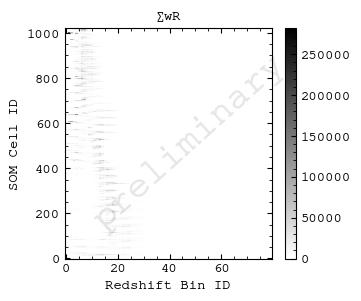

In [94]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    _nz,
    origin="lower",
    vmin=0
)
axs.set_xlabel("Redshift Bin ID")
axs.set_ylabel("SOM Cell ID")
axs.set_title("$\\sum w R$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

lib.plotting.watermark(fig)

plt.show()

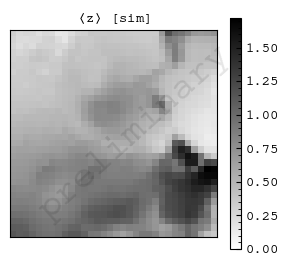

In [95]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.imshow(
    (
        np.sum(zbinsc * _nz, axis=1) 
        / np.sum(_nz, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0
)
axs.set_title("$〈z〉$ [sim]")

fig.colorbar(im, ax=axs)

axs.set_xticks([])
axs.set_yticks([])

lib.plotting.watermark(fig)

plt.show()

---

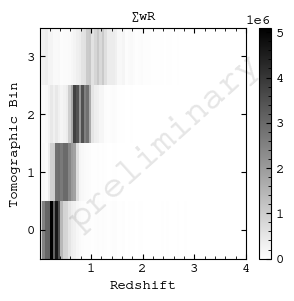

In [96]:
fig, axs = plt.subplots(1, 1, figsize=(3 + 4/12, 3))

im = axs.pcolormesh(
    zbinsc,
    lib.const.TOMOGRAPHIC_BINS,
    np.array(
        [
            np.sum(
                _nz[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
                axis=0,
            )
            for tomographic_bin in lib.const.TOMOGRAPHIC_BINS
        ]
    ),
    vmin=0
)
axs.set_xlabel("Redshift")
axs.set_ylabel("Tomographic Bin")
axs.set_title("$\\sum w R$")

axs.set_aspect("auto")

fig.colorbar(im, ax=axs)

# axs.set_xticks([])
axs.set_yticks([0, 1, 2, 3])
axs.set_yticks([], minor=True)

lib.plotting.watermark(fig)

plt.show()

---

# Nominal

In [182]:
nz = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz[tomographic_bin] = np.sum(
        _nz[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )

    # renormalize
    nz[tomographic_bin] = nz[tomographic_bin] / np.sum(nz[tomographic_bin]) / np.diff(zedges)

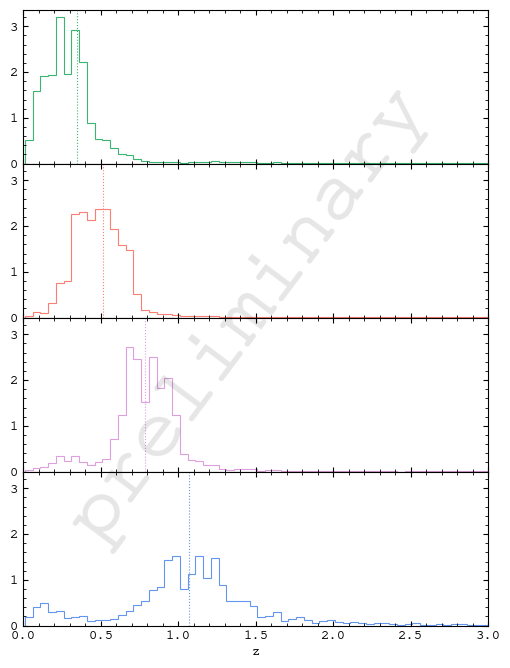

In [98]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz[i],
        edges=zedges,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

lib.plotting.watermark(fig)

plt.show()

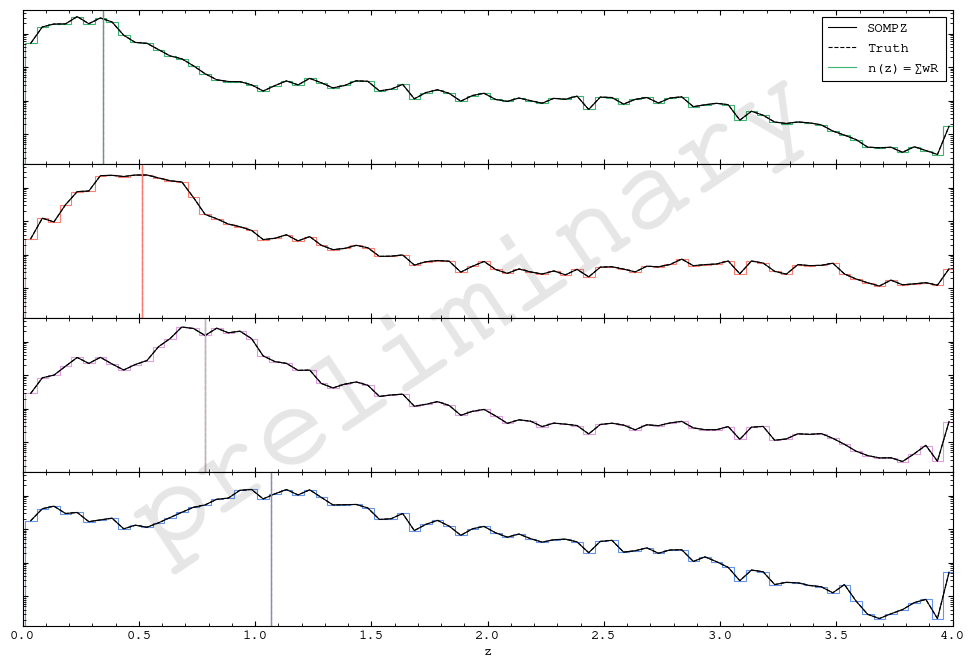

In [99]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(12, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz_sompz[i]),
        c="k",
        ls="-",
    )
    axs[i].plot(
        zbinsc,
        nz_sompz[i],
        c="k",
        ls="-",
        label="SOMPZ",
    )
    axs[i].axvline(
        np.average(zbinsc, weights=nz_true[i]),
        c="k",
        ls="--",
    )
    axs[i].plot(
        zbinsc,
        nz_true[i],
        c="k",
        ls="--",
        label="Truth",
    )
    
    axs[i].axvline(
        np.average(zbinsc, weights=nz[i]),
        c=tomo_colors[i],
        ls="-",
    )
    axs[i].stairs(
        nz[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="-",
        label="$n(z) = \\sum w R$",
    )

axs[-1].set_xlim(0, 4)
# axs[-1].set_ylim(0, None)
axs[-1].set_yscale("log")

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].legend(loc="upper right")

lib.plotting.watermark(fig)

plt.show()

# Variants

In [181]:
nz_raw = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_raw[tomographic_bin] = np.sum(
        _nz_raw[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )

    # renormalize
    nz_raw[tomographic_bin] = nz_raw[tomographic_bin] / np.sum(nz_raw[tomographic_bin]) / np.diff(zedges)

In [155]:
nz_response_val = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_response_val[tomographic_bin] = np.sum(
        _nz_val[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )

    # renormalize
    nz_response_val[tomographic_bin] = nz_response_val[tomographic_bin] / np.sum(nz_response_val[tomographic_bin]) / np.diff(zedges)

In [156]:
nz_response = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_response[tomographic_bin] = np.sum(
        # (_nz_raw * som_response_sim[:, np.newaxis])[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        _nz_alt[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )

    # renormalize
    nz_response[tomographic_bin] = nz_response[tomographic_bin] / np.sum(nz_response[tomographic_bin]) / np.diff(zedges)

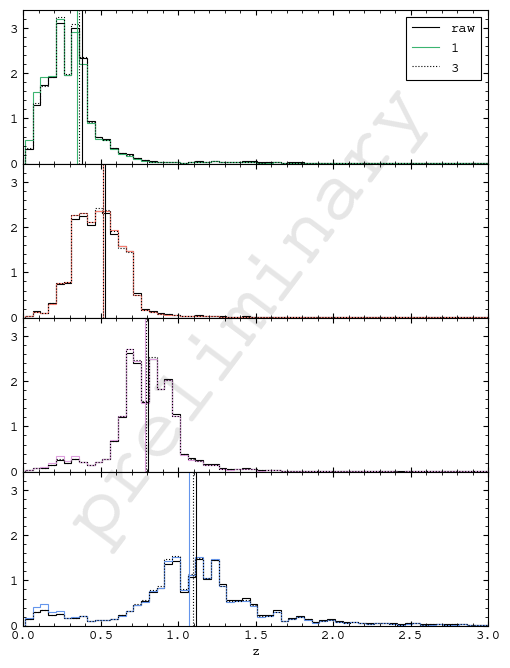

In [186]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz_raw[i]),
        c="k",
    )
    axs[i].stairs(
        nz_raw[i],
        edges=zedges,
        ec="k",
        label="raw",
    )
    
    axs[i].axvline(
        np.average(zbinsc, weights=nz[i]),
        c=tomo_colors[i],
    )
    axs[i].stairs(
        nz[i],
        edges=zedges,
        ec=tomo_colors[i],
        label="1",
    )
    
    # axs[i].axvline(
    #     np.average(zbinsc, weights=nz_response_val[i]),
    #     c=tomo_colors[i],
    #     ls="--",
    # )
    # axs[i].stairs(
    #     nz_response_val[i],
    #     edges=zedges,
    #     ec=tomo_colors[i],
    #     ls="--",
    #     label="2",
    # )

    axs[i].axvline(
        np.average(zbinsc, weights=nz_response[i]),
        c="k",
        ls=":",
    )
    axs[i].stairs(
        nz_response[i],
        edges=zedges,
        ec="k",
        ls=":",
        label="3",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
axs[0].legend()

lib.plotting.watermark(fig)

plt.show()

In [193]:
print("mean z")
print(
    f"--------"
    f"--------"
    f"--------"
    f"--------"
)
print(
    f"bin"
    f"\tsompz"
    f"\traw"
    f"\tresponse"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc, weights=nz_sompz[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_raw[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_response[i]) :.4f}"
    )


mean z
--------------------------------
bin	sompz	raw	response
0	0.3460	0.3810	0.3606
1	0.5128	0.5285	0.5127
2	0.7862	0.8025	0.7950
3	1.0666	1.1123	1.0931


In [101]:
nz_occupancy_ratio = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_occupancy_ratio[tomographic_bin] = np.sum(
        (_nz * (som_occupancy_y6 / som_occupancy_sim)[:, np.newaxis])[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )

    # renormalize
    nz_occupancy_ratio[tomographic_bin] = nz_occupancy_ratio[tomographic_bin] / np.sum(nz_occupancy_ratio[tomographic_bin]) / np.diff(zedges)

In [102]:
nz_weight_ratio = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_weight_ratio[tomographic_bin] = np.sum(
        (_nz * (som_weight_y6 / som_weight_sim)[:, np.newaxis])[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )

    # renormalize
    nz_weight_ratio[tomographic_bin] = nz_weight_ratio[tomographic_bin] / np.sum(nz_weight_ratio[tomographic_bin]) / np.diff(zedges)

In [104]:
nz_response_ratio = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_response_ratio[tomographic_bin] = np.sum(
        (_nz * (som_grid_response_y6 / som_grid_response_sim)[:, np.newaxis])[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )

    # renormalize
    nz_response_ratio[tomographic_bin] = nz_response_ratio[tomographic_bin] / np.sum(nz_response_ratio[tomographic_bin]) / np.diff(zedges)

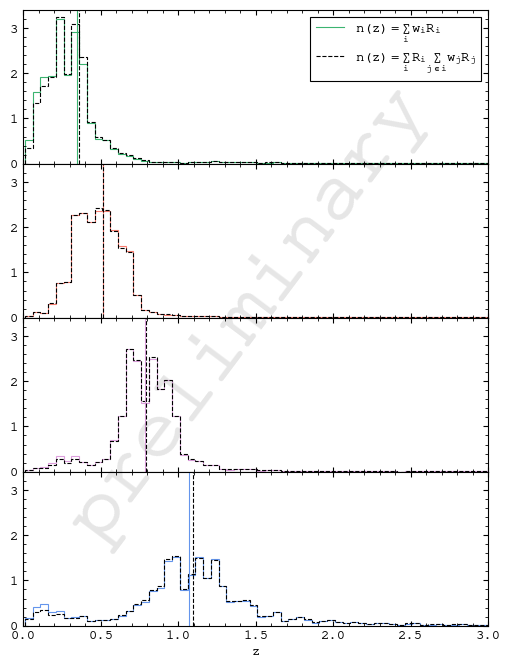

In [157]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz[i]),
        c=tomo_colors[i],
    )
    axs[i].stairs(
        nz[i],
        edges=zedges,
        ec=tomo_colors[i],
        label="$n(z) = \\sum_i\\ w_i R_i$",
    )

    axs[i].axvline(
        np.average(zbinsc, weights=nz_response[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_response[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="$n(z) = \\sum_i\\ R_i \\sum_{j \in i} w_j R_j$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
axs[0].legend()

lib.plotting.watermark(fig)

plt.show()

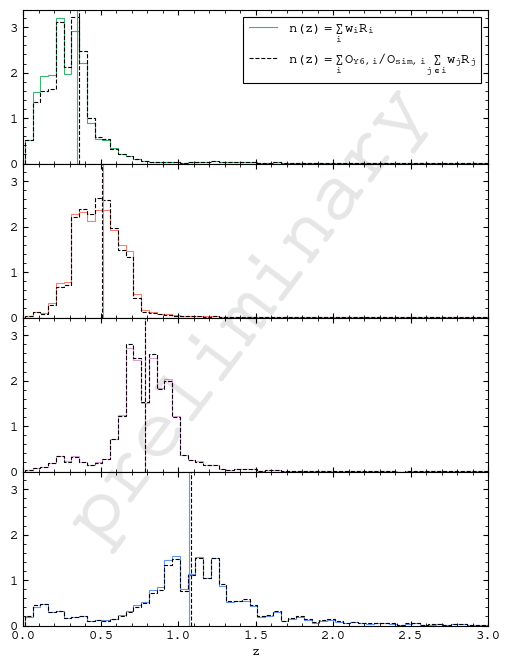

In [148]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz[i]),
        c=tomo_colors[i],
    )
    axs[i].stairs(
        nz[i],
        edges=zedges,
        ec=tomo_colors[i],
        label="$n(z) = \\sum_i\\ w_i R_i$",
    )

    axs[i].axvline(
        np.average(zbinsc, weights=nz_occupancy_ratio[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_occupancy_ratio[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="$n(z) = \\sum_i\\ O_{Y6, i} / O_{sim, i} \\sum_{j \in i} w_j R_j$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
axs[0].legend()

lib.plotting.watermark(fig)

plt.show()

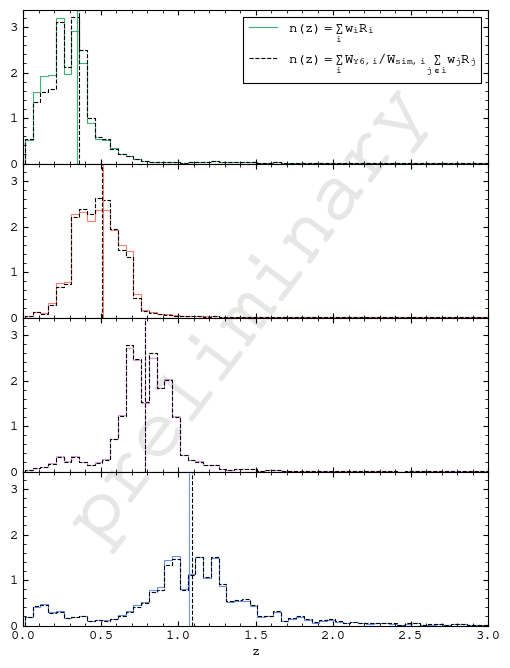

In [149]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz[i]),
        c=tomo_colors[i],
    )
    axs[i].stairs(
        nz[i],
        edges=zedges,
        ec=tomo_colors[i],
        label="$n(z) = \\sum_i\\ w_i R_i$",
    )

    axs[i].axvline(
        np.average(zbinsc, weights=nz_weight_ratio[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_weight_ratio[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="$n(z) = \\sum_i\\ W_{Y6, i} / W_{sim, i} \\sum_{j \in i} w_j R_j$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
axs[0].legend()

lib.plotting.watermark(fig)

plt.show()

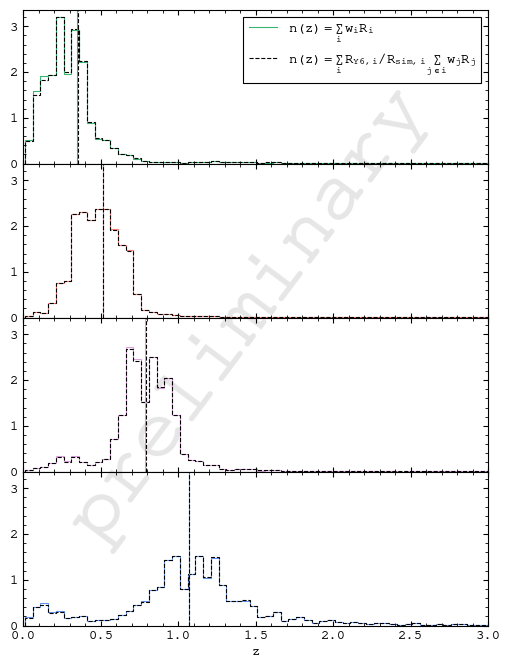

In [150]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(zbinsc, weights=nz[i]),
        c=tomo_colors[i],
    )
    axs[i].stairs(
        nz[i],
        edges=zedges,
        ec=tomo_colors[i],
        label="$n(z) = \\sum_i\\ w_i R_i$",
    )

    axs[i].axvline(
        np.average(zbinsc, weights=nz_response_ratio[i]),
        c="k",
        ls="--",
    )
    axs[i].stairs(
        nz_response_ratio[i],
        edges=zedges,
        ec="k",
        ls="--",
        label="$n(z) = \\sum_i\\ R_{Y6, i} / R_{sim, i} \\sum_{j \in i} w_j R_j$",
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
axs[0].legend()

lib.plotting.watermark(fig)

plt.show()

---

# Comparison

In [151]:
print("mean z")
print(
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
)
print(
    f"\tboyan"
    f"\t"
    f"\tsmau"
)
print(
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
    f"--------"
)
print(
    f"bin"
    f"\tsompz"
    f"\ttruth"
    f"\tnz"
    f"\tR"
    f"\tO/O"
    f"\tW/W"
    f"\tR/R"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc, weights=nz_sompz[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_true[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_response[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_occupancy_ratio[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_weight_ratio[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_response_ratio[i]) :.4f}"
    )


mean z
----------------------------------------------------------------
	boyan		smau
----------------------------------------------------------------
bin	sompz	truth	nz	R	O/O	W/W	R/R
0	0.3460	0.3460	0.3460	0.3507	0.3589	0.3599	0.3534
1	0.5128	0.5129	0.5129	0.5139	0.5072	0.5075	0.5149
2	0.7862	0.7862	0.7862	0.7926	0.7846	0.7860	0.7890
3	1.0666	1.0664	1.0664	1.0928	1.0844	1.0865	1.0726
